In [69]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import matplotlib.dates as mdates


In [70]:
olist_customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ro-a/product/FinalWork/olist_customers_dataset.csv')

In [71]:
olist_order_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ro-a/product/FinalWork/olist_order_items_dataset.csv')

In [72]:
olist_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ro-a/product/FinalWork/olist_orders_dataset.csv')

In [73]:
olist_order = pd.merge(olist_customers, olist_orders, on = 'customer_id')

In [74]:
olist_order = olist_order[olist_order['order_status'] == 'delivered']

In [75]:
olist_order = olist_order.dropna()

In [76]:
# Перевожу дату в формат datetime
olist_order['order_purchase_timestamp'] = pd.to_datetime(olist_order['order_purchase_timestamp'])
olist_order['order_approved_at'] = pd.to_datetime(olist_order['order_approved_at'])
olist_order['order_delivered_customer_date'] = pd.to_datetime(olist_order['order_delivered_customer_date'])

In [77]:
# Извлекаю месяц и день
olist_order['order_period'] = olist_order['order_approved_at'].dt.to_period('M')
olist_order['order_period_day'] = olist_order['order_approved_at'].dt.to_period('D')

In [78]:
# Присваиваю когорты на основе даты первого действия пользователя
olist_order['cohort'] = olist_order.groupby('customer_unique_id')['order_purchase_timestamp']\
.transform('min').dt.to_period('M')
olist_order['cohort_day'] = olist_order.groupby('customer_unique_id')['order_purchase_timestamp']\
.transform('min').dt.to_period('D')

In [79]:
# Рассчитываем номер периода в днях (месячные периоды, деля на 30)
olist_order['period_number_month'] = np.floor((olist_order.order_period_day - olist_order.cohort_day).apply(attrgetter('n')) / 30)

In [80]:
df_cohort = olist_order.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_id','nunique')).reset_index()

In [81]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [82]:
cohort_pivot.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,265.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,749.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1642.0,2.0,3.0,6.0,4.0,2.0,5.0,1.0,1.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN


In [83]:
cohort_size = cohort_pivot.iloc[:,0]

In [84]:
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [85]:
pd.set_option('display.max_rows', None)

In [88]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
retention_matrix.median()

period_number_month
0.0     1.000000
1.0     0.003600
2.0     0.003053
3.0     0.002608
4.0     0.002304
5.0     0.001872
6.0     0.002670
7.0     0.001826
8.0     0.001565
9.0     0.002436
10.0    0.002067
11.0    0.002592
12.0    0.001565
13.0    0.001826
14.0    0.001614
15.0    0.001156
16.0    0.001243
17.0    0.002249
19.0    0.004441
20.0    0.003774
21.0    0.003774
dtype: float64

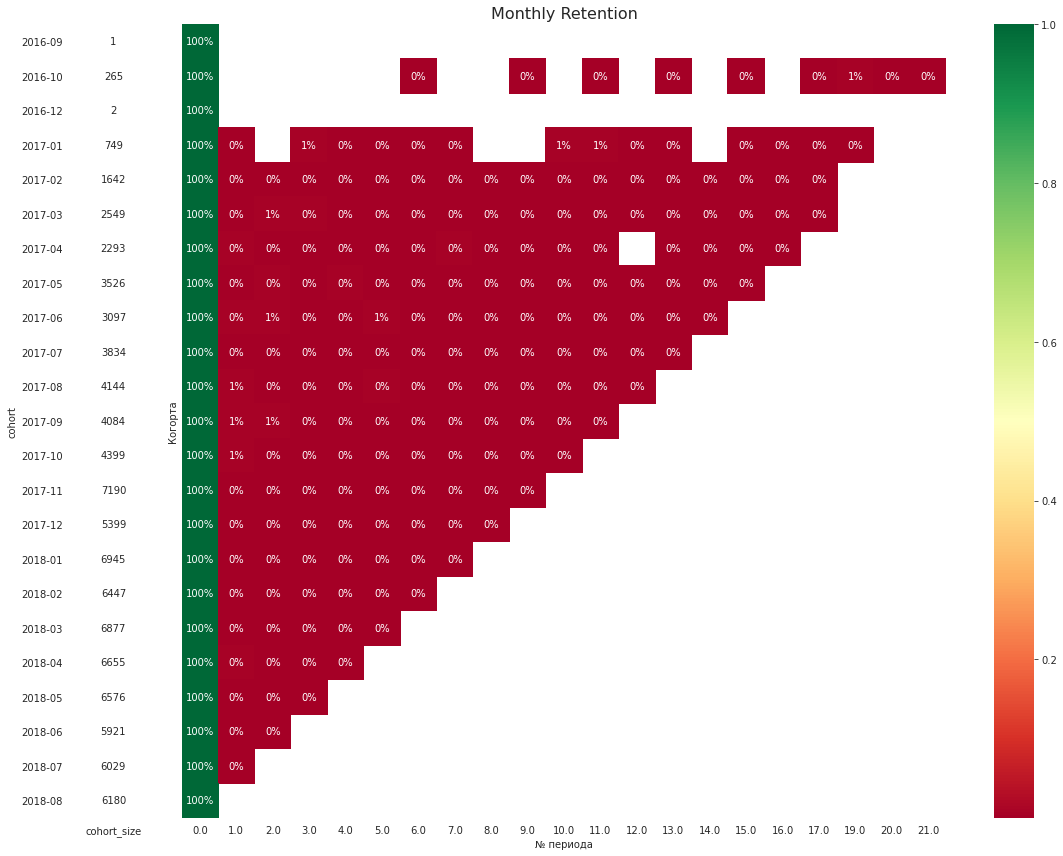

In [19]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

Когортный анализ:
Большинство пользователей совершают единоразовую покупку
В последующие недели не возвращаются — когорты стремятся к нулю
Устойчивого ретеншена не наблюдается

Вывод:
Product/Market Fit отсутствует
Продукт не закрепляется в поведении пользователей, они не видят в нём долгосрочной ценности

Возможные причины:
Неудовлетворённые ожидания от сервиса
Слабый ассортимент, низкое качество или неудобный интерфейс
Отсутствие мотивации вернуться (нет программ лояльности, напоминаний)

Рекомендации:
Провести интервью с пользователями: что не понравилось? почему не вернулись?
Проанализировать весь путь пользователя (user journey) — на каком этапе теряется интерес
Провести A/B-тесты с новыми фичами или улучшениями (например, рекомендации, кешбэк, подписки)

<!-- Задача 3 -->
1. Общий объём продаж через маркетплейс за месяц.
2. Число уникальных пользователей, совершивших целевое действие за месяц 
3. Доля новых пользователей, которые совершили целевое действие в первый месяц после регистрации
4. Доля пользователей, вернувшихся в последующие месяцы после первого использования
5. Средняя выручка на одного активного пользователя в месяц.

1. Общий объём продаж через маркетплейс за месяц.

In [20]:
df = pd.merge(olist_order, olist_order_items, on='order_id')

In [21]:
gmv = df.groupby('order_period', as_index=False).agg({'price':'sum'}).sort_values('order_period', ascending=False)

In [22]:
gmv['order_period'] = gmv['order_period'].dt.to_timestamp()

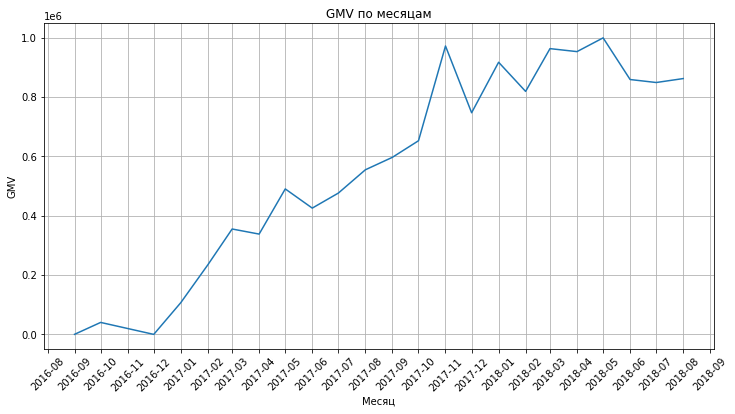

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=gmv, x='order_period', y='price')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.title('GMV по месяцам')
plt.ylabel('GMV')
plt.xlabel('Месяц')
plt.grid(True)
plt.show()

In [24]:
gmv

,order_period,price
22,2018-08-01,862639.54
21,2018-07-01,849351.12
20,2018-06-01,859396.90
19,2018-05-01,999867.28
18,2018-04-01,953526.94
17,2018-03-01,963604.25
16,2018-02-01,819355.27
15,2018-01-01,917667.20
14,2017-12-01,747390.69
13,2017-11-01,972486.88


2. Число уникальных пользователей, совершивших целевое действие за месяц 

In [25]:
mau = df.groupby('order_period')['customer_unique_id'].nunique().reset_index()

In [26]:
mau.rename(columns={'customer_unique_id': 'mau'}, inplace=True)

In [27]:
mau['order_period'] = mau['order_period'].dt.to_timestamp()

In [28]:
mau

,order_period,mau
0,2016-09-01,1
1,2016-10-01,262
2,2016-12-01,1
3,2017-01-01,684
4,2017-02-01,1615
5,2017-03-01,2516
6,2017-04-01,2249
7,2017-05-01,3481
8,2017-06-01,3084
9,2017-07-01,3759


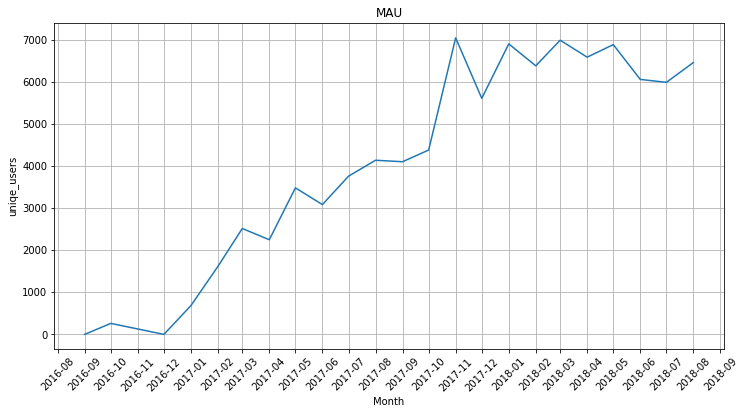

In [29]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=mau, x='order_period', y='mau')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.title('MAU')
plt.ylabel('uniqe_users')
plt.xlabel('Month')
plt.grid(True)
plt.show()

4. Доля пользователей, вернувшихся в последующие месяцы после первого использования

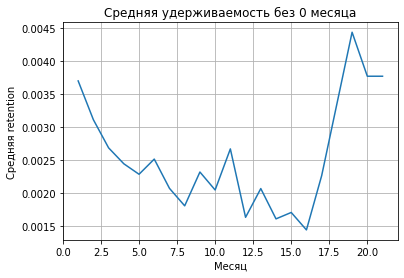

In [30]:
avg_retention = retention_matrix.mean().iloc[1:]  # исключаю 0 месяц
sns.lineplot(data=avg_retention)
plt.title('Средняя удерживаемость без 0 месяца')
plt.xlabel('Месяц')
plt.ylabel('Средняя retention')
plt.grid(True)
plt.show()

5. Средняя выручка на одного активного пользователя в месяц.

In [31]:
arpu = pd.merge(gmv, mau, on = 'order_period')

In [32]:
arpu

,order_period,price,mau
0,2018-08-01,862639.54,6459
1,2018-07-01,849351.12,5988
2,2018-06-01,859396.90,6057
3,2018-05-01,999867.28,6884
4,2018-04-01,953526.94,6586
5,2018-03-01,963604.25,6989
6,2018-02-01,819355.27,6380
7,2018-01-01,917667.20,6901
8,2017-12-01,747390.69,5608
9,2017-11-01,972486.88,7044


In [33]:
arpu['arpu'] = arpu['price']/arpu['mau']

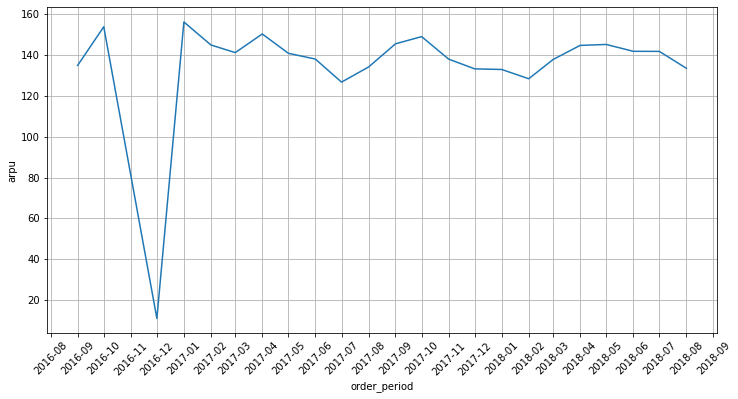

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=arpu, x='order_period', y='arpu')


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

plt.grid(True)
plt.show()

In [35]:
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ro-a/product/FinalWork/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp'])

# Отбираем заказы с июня 2017
orders = orders[orders['order_purchase_timestamp'] >= '2017-06-01']


Гипотеза 1

In [36]:
# Количество отменённых заказов (не доставлены)
canceled = orders[orders['order_status'] != 'delivered'].shape[0]
# Это прирост при полном устранении отмен
impact1 = canceled

Гипотеза 2 и 3 — через retention 1 месяца

In [108]:
# Уникальные пользователи, сделавшие первый заказ с июня 2017
first_time_users = orders['customer_id'].nunique()

# Прирост заказов с ретеншном 0.0036
impact2 = int(first_time_users * 0.0035)
impact3 = int(first_time_users * 0.0035)


In [109]:
def convert_to_impact_scale(value):
    bins = [0, 50, 150, 350, 750, 1550, 3150, 6350, 12750, 25550, 51150]
    for i in range(1, len(bins)):
        if bins[i-1] < value <= bins[i]:
            return i
    return 10


In [110]:
impact_score1 = convert_to_impact_scale(impact1)
impact_score2 = convert_to_impact_scale(impact2)
impact_score3 = convert_to_impact_scale(impact3)

ice1 = impact_score1 * 8 * 6
ice2 = impact_score2 * 10 * 4
ice3 = impact_score3 * 5 * 9

In [111]:
ice1

288

In [112]:
ice2

120

In [113]:
ice3

135

Выбираем 1 гипотезу

Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

Целевая метрика
Конверсия в доставку

Прокси-метрика
Среднее время доставки

Guardrail-метрика
Количество обращений в службу поддержки

Общие выводы по итогу исследования

Основные продуктовые метрики маркетплейса были сформулированы и визуализированы
GMV (объём продаж),
MAU (уникальные активные пользователи),
Retention (удержание клиентов),
ARPU (средний доход на пользователя).

Когортный анализ показал, что удержание клиентов после первого месяца существенно падает.
Медианное значение retention для 1-го месяца — всего 0.0035, что указывает на низкую лояльность и редкие повторные заказы.

Гипотезы по улучшению продукта были оценены с помощью фреймворка ICE.
После пересчёта с актуальными данными победила гипотеза:

Устранить баг, вызывающий отмену заказов, чтобы увеличить количество доставленных заказов (ICE = 288)

Метрики для A/B-теста были сформулированы — целевая, прокси и guardrail


Рекомендации по продукту

Внедрить исправление отмен заказов в первую очередь

В будущем вернуться к гипотезе о новом способе оплаты — она показывает хороший потенциал при низких трудозатратах (Ease = 9), и может усилить эффект от повышения доставок.